# Algorithm pipeline & GridSearch, Simple my AutoML

This notebook includes training pipeline building with grid search.Several algorithm and parameters can be evaluated at one notebook.Too many parameters variation needs long time for training.  
This notebook does not include detail EDA process, but show data process flow, like a simple Auto ML.

1. Preparation  
    1-1. import libraries  
    1-2. Path setting  
    1-3. Setting for Training, Prediction and Submission  
2. Load Dataset  
    2-1. Read csv file  
    2-2. Check missing value  
3. Data Preprocessing  
    3-1. One Hot Encoding  
    3-2. Dimension compression with RFE  
4. Pipeline Definition  
    4-1. Define algorithm in pipeline  
    4-2. Parameter for Gridsearch Setting  
5. Training  
    5-1. Training  
    5-2. Selecting models for test data prediction  
    5-3. Re-training wiht all data on selected model  
6. Prediction  
    6-1. Load test data  
    6-2. One-Hot-Encoding  
    6-3. Difference at columns between training data and test data  
    6-4. Prediction  
7. Submission  
    7-1. provide predicted data for submission  
    7-2. Generate csv file  

(Added explanation)
In 18 code is for notebook save & run. The radio button selection can not be used in the save & run.If you copy & edit this notebook, radio button can be used for algorithm selection 

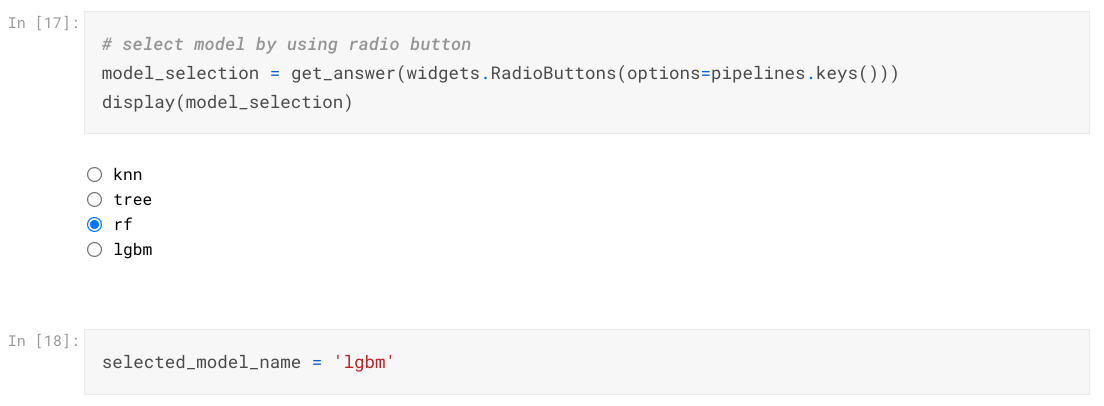

## 1. Preparation

### 1-1. import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

# Dimension compression
from sklearn.feature_selection import RFE

# Algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# widget
from ipywidgets import interact,interactive,fixed,interact_manual
from IPython.display import display
import ipywidgets as widgets

In [ ]:
# Change view options
pd.options.display.max_columns = 50

### 1-2. Path setting

In [ ]:
# file path(train data and test data)
train_file = '../input/tabular-playground-series-may-2021/train.csv'
test_file = '../input/tabular-playground-series-may-2021/test.csv'

### 1-3. Setting for Training, Prediction and Submission

In [ ]:
# column name for submission file
ID_column = 'id'

# column name of the target data
target = 'target'
submission_cols = ['Class_1', 'Class_2', 'Class_3', 'Class_4']

# create list to reject columns from dataset for train dataset preparation
unuse_columns_for_train = [ID_column,]
train_reject_items = unuse_columns_for_train + [target]

In [ ]:
# one-hot-encoding columns (categorical data)
ohe_columns = []

# create dic to set data type for each column
my_dtype = {k: object  for k in ohe_columns}
print(my_dtype)

## 2. Load Dataset  
### 2-1. Read csv file
load data to provide training dataset

In [ ]:
# read csv file
dataset = pd.read_csv(train_file, header=0)

# To drop reject items columns from train data set
# pandas.core.frame.DataFrame
X = pd.DataFrame(dataset).drop(columns=train_reject_items, axis=1)

# pandas.core.series.Series
y = pd.Series(dataset[target])

# replace target value as below
dic={"Class_1":0, "Class_2":1, "Class_3":2, "Class_4":3}
y.replace(dic, inplace=True)

# check the shape
print('----------------------------------------------------------------')
print('X shape: (%i,%i)' %X.shape)
print('----------------------------------------------------------------')
print('y shape: (%i,)' %y.shape)
print('----------------------------------------------------------------')
print(y.value_counts())
print('----------------------------------------------------------------')
print()
print('dataset:csv file raw data')
display(dataset.head())
print('X: Train dataset')
X.join(y).head()

### 2-2. Check missing value

In [ ]:
# Check missing value in each column of dataset
dataset.isnull().sum()

## 3. Data Preprocessing

### 3-1. One Hot Encoding
One hot encoding process for tha data of categorical data along with ohe_columns list

In [ ]:
def one_hot_encoding(data, ohe_columns):
    X_ohe = pd.get_dummies(data,
                       dummy_na=True,    # True:including missing value
                       columns=ohe_columns)
    print('X_ohe shape:(%i,%i)' % X_ohe.shape)
    display(X_ohe.head())
    return X_ohe
    
X_ohe = one_hot_encoding(X, ohe_columns)
X_ohe_columns = X_ohe.colimns.values

In [ ]:
X_ohe_columns = X_ohe.columns.values
X_ohe_columns

### 3-2. Dimension compression with RFE

In [ ]:
# Parameters of RFE dimension compression
n_estimators=100
n_features_to_select=50
step=.05

In [ ]:
def dimension_compression(X_ohe, y):
    start = time.time()
    selector = RFE(RandomForestClassifier(n_estimators=n_estimators, random_state=1),
               n_features_to_select=n_features_to_select, # number of column number after compression
               step=step)
    selector.fit(X_ohe,y)
    X_ohe_columns =  X_ohe.columns.values
    
    # selector.support_ list of True or False
    X_fin = X_ohe.loc[:, X_ohe_columns[selector.support_]]
    
    # Duration time
    duration = time.time() - start
    print(duration,'s')
    
    print('Duration Time:', 'X_fin shape:(%i,%i)' % X_fin.shape)
    display(X_fin.head())
    return X_fin, selector
    
X_fin, selector = dimension_compression(X_ohe, y)

In [ ]:
 selector

In [ ]:
print('-----------------------------------')
print('X_fin shape: (%i,%i)' %X_fin.shape)
print('-----------------------------------')
print(y.value_counts())
print('--------------------------------------------------')
print('--------------------------------------------------')
print('y shape: (%i,)' %y.shape)
print('--------------------------------------------------')

In [ ]:
# data split for train and test
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.2, random_state=46, stratify=y)

In [ ]:
X_train.shape

## 4. Pipeline Definition  
### 4-1. Define algorithm in pipeline
describe ML algorithm as a dictionary type

In [ ]:
# set pipelines for different algorithms
pipelines = {
    'knn':
        Pipeline([('scl',StandardScaler()),
                    ('est',KNeighborsClassifier())]),
    'tree':
        Pipeline([('scl',StandardScaler()),
                    ('est',DecisionTreeClassifier(random_state=1))]),
    'rf':
        Pipeline([('scl',StandardScaler()),
                    ('est',RandomForestClassifier(random_state=1))]),

    'lgbm':
        Pipeline([('scl',StandardScaler()),
                    ('est',lgb.LGBMClassifier())]),
}

### 4-2. Parameter for Gridsearch Setting  
Many parameters needs long time for training.

In [ ]:
params = {
    'knn' : {'est__n_neighbors':[5, ],
             'est__weights':['uniform','distance'],},
    
    'tree': {'est__max_depth': list(range(10, 20)),
            'est__criterion': ['gini', 'entropy'],},
    
    'rf': {'est__n_estimators':[100, 300],
            'est__max_depth': [8, 10,],
            'est__random_state': [0],},
    
    'lgbm': {'est__max_depth':[10, 50,],
            'est__learning_rate':[0.01,0.1],
            'est__num_leaves':[31, 64],
            'est__n_estimators':[100, 500,],},
}

## 5. Training  
### 5-1. Training
training on pipeline and grid search

In [ ]:
#  evaluation parameter
evaluation_scoring = 'accuracy'

# instance initialization for score data durring grid search
scores = {}
best_params ={}
best_scores ={}

# training pipeline with grid search
for pipe_name, pipeline in pipelines.items():
    print(pipe_name)
    print(params[pipe_name])
    start = time.time()
    gs = GridSearchCV(estimator=pipeline,
                     param_grid = params[pipe_name],
                     scoring=evaluation_scoring,
                     cv=5,
                     return_train_score=False)
    # train
    gs.fit(X_train, y_train)
    
    print('time', time.time()-start)
    scores[(pipe_name,'train')] = accuracy_score(y_train, gs.predict(X_train))
    scores[(pipe_name,'test')] = accuracy_score(y_test, gs.predict(X_test))
    best_params[pipe_name] = gs.best_params_
    best_scores[pipe_name] = gs.best_score_
    
    # create directories for each models
    os.makedirs('/kaggle/working/models/pipeline_models', exist_ok=True)
     # save created model 
    file_name = '/kaggle/working/models/pipeline_models/'+pipe_name+str(time.time())+'.pkl'
    pickle.dump(pipeline, open(file_name, 'wb'))

print('---accuracy---')
pd.Series(scores).unstack()

### 5-2. Selecting models for test data prediction  
select algorithm model for submission from pipeline  

In [ ]:
def get_answer(x):
    return x

Display radio button and select model

In [ ]:
# select model by using radio button
model_selection = get_answer(widgets.RadioButtons(options=pipelines.keys()))
display(model_selection)

The above radio button can be used for algorithm selection.  
But the top algorithm is selected when the save & run.  

In [ ]:
selected_model_name = 'lgbm'

In [ ]:
# check selected model name
# selected_model_name = model_selection.value
print(selected_model_name)

### 5-3. Re-training wiht all data on selected model

To choose "selected model" from pipeline , GridSearchCV is used with signal algorithm and parameter.

In [ ]:
X_fin.shape

In [ ]:
def train_on_selected_model(pipe_name, pipelines, params, evaluation_scoring, tag):
    start = time.time()
    gs = GridSearchCV(estimator=pipelines[pipe_name],
                     param_grid = params,
                     scoring=evaluation_scoring,
                     cv=5,
                     return_train_score=False)
    # Train with all data
    # model = gs.fit(X_train, y_train)
    model = gs.fit(X_fin, y)
    
    print('time', time.time()-start)
    scores[(pipe_name,'train')] = accuracy_score(y_train, gs.predict(X_train))
    scores[(pipe_name,'test')] = accuracy_score(y_test, gs.predict(X_test))
    
    # create dirs to save pkl model
    os.makedirs('/kaggle/working/models/', exist_ok=True)
    # save pkl
    file_name = '/kaggle/working/models/' + pipe_name + '_' + tag + str(time.time())+'.pkl'
    pickle.dump(model, open(file_name, 'wb'))
    
    return model

In [ ]:
# to cast type of best_params[seleced_model_name] value to list type
def params_parser(best_params, selected_model_name):
    return {k:[v] for k,v in best_params[selected_model_name].items()}

best_param_parsed = params_parser(best_params, selected_model_name)
print(best_param_parsed)

In [ ]:
# Re-train with all data on selected model
selected_model = train_on_selected_model(selected_model_name, pipelines, best_param_parsed, evaluation_scoring, 'selected')

## 6. Prediction  
prediction with test data

### 6-1. Load Test Data

In [ ]:
# read test data
dataset_s = pd.read_csv(test_file,header=0)

# To drop reject items columns from train data set
# pandas.core.frame.DataFrame
ID_s = dataset_s.iloc[:,[0]]
X_s = dataset_s.drop(unuse_columns_for_train, axis=1)

# # check the shape
print('-----------------------------------')
print('Raw Shape: (%i, %i)' %dataset_s.shape)
print('X_s Shape: (%i, %i)' %X_s.shape)
print('-----------------------------------')
print(X_s.dtypes)
ID_s.join(X_s).head()

### 6-2. One-Hot-Encodeing for test data

In [ ]:
X_ohe_s = pd.get_dummies(X_s,
                         dummy_na=True,
                         columns=ohe_columns)
print('X_ohe_s shape:(%i,%i)' % X_ohe_s.shape)
X_ohe_s.head(3)

### 6-3. Difference at columns between training data and test data  
Compare column between X_ohe and X_ohe_s after One-Hot-Encoding  

In [ ]:
cols_model= set(X_ohe.columns.values)
cols_score = set(X_ohe_s.columns.values)

diff1 = cols_model - cols_score
print('Columns of existing in training data:: %s' %diff1)

diff2 = cols_score - cols_model
print('Columns of existing in test data for submission: %s' %diff2)

In [ ]:
# DataFrame X_ohe
# Case1: Train data have, Test data does not have column -> Fill "0"
# Case2: Train data does not have, Test data have column -> Drop

dataset_cols_m = pd.DataFrame(None,
                         columns=X_ohe.columns.values,
                         dtype=float)
display(dataset_cols_m)

X_ohe_s = pd.concat([dataset_cols_m, X_ohe_s])
print(X_ohe_s.shape)
display(X_ohe_s.head(3))

In [ ]:
# Concat Empty DataFrame and test data(X_s)
X_ohe_s = pd.concat([dataset_cols_m, X_ohe_s])
print(X_ohe_s.shape)
display(X_ohe_s.head(3))

In [ ]:
set_Xm = set(X_ohe.columns.values)
set_Xs = set(X_ohe_s.columns.values)
print(set_Xs-set_Xm)
X_ohe_s = X_ohe_s.drop(list(set_Xs-set_Xm),axis=1)

print(X_ohe_s.shape)
display(X_ohe_s.head(3))

Case1: Train data have, Test data does not have column -> Fill "0"

In [ ]:
print(set_Xm-set_Xs)
X_ohe_s.loc[:,list(set_Xm-set_Xs)] = X_ohe_s.loc[:,list(set_Xm-set_Xs)].fillna(0,axis=1)
print(X_ohe_s.shape)
X_ohe_s.head(3)

Case2: Train data does not have, Test data have column -> Drop

In [ ]:
X_ohe_s = X_ohe_s.reindex(X_ohe_columns, axis=1)
X_ohe_s.head(3)
print(X_ohe_s.shape)

Select columns after dimension compressing

In [ ]:
selector.support_

In [ ]:
X_fin_s = X_ohe_s.loc[:, X_ohe_columns[selector.support_]]
print(X_fin_s.shape)
X_fin_s.head(3)

### 6-4. Prediction

In [ ]:
# prediction
y_pred = selected_model.predict_proba(X_fin_s)
print(len(y_pred))

## 7. Submission  
### 7-1. provide predicted data for submission

In [ ]:
id_df=pd.DataFrame(data=ID_s,columns=[ID_column])

submission_column_list =  ['Class_1','Class_2', 'Class_3', 'Class_4']
result_df = pd.DataFrame(data=y_pred,columns=submission_column_list)
submit_df = pd.concat([id_df, result_df], axis=1)
submit_df.head()

### 7-2. Generate csv file

In [ ]:
# Setting for submission file
submit_file_dir = '/kaggle/working/'
submit_file_name = 'submission.csv'

# make directories for submittion file
os.makedirs(submit_file_dir, exist_ok=True)

# To generate csv file for submittion
submit_df.to_csv(submit_file_dir + submit_file_name , index=False)